In [69]:
import sys
from itertools import groupby

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from scipy.interpolate import make_interp_spline
from colorama import Fore
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import math


In [4]:
device = torch.device('cpu')

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size: int, num_heads: int, dropout: float = 0.2, batch_dim: int = 0):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_dim = batch_dim

        self.dropout_layer = nn.Dropout(dropout)

        self.head_size = self.embed_size // self.num_heads

        assert self.head_size * self.num_heads == self.embed_size, "Heads cannot split Embedding size equally"

        self.Q = nn.Linear(self.embed_size, self.embed_size)
        self.K = nn.Linear(self.embed_size, self.embed_size)
        self.V = nn.Linear(self.embed_size, self.embed_size)

        self.linear = nn.Linear(self.embed_size, self.embed_size)

    def forward(self, q, k, v, mask=None):
        if self.batch_dim == 0:
            out = self.batch_0(q, k, v, mask)
        elif self.batch_dim == 1:
            out = self.batch_1(q, k, v, mask)

        return out

    def batch_0(self, q, k, v, mask=None):
        q_batch_size, q_seq_len, q_embed_size = q.size()
        k_batch_size, k_seq_len, k_embed_size = k.size()
        v_batch_size, v_seq_len, v_embed_size = v.size()

        q = self.Q(q).reshape(q_batch_size, q_seq_len, self.num_heads, self.head_size)
        k = self.K(k).reshape(k_batch_size, k_seq_len, self.num_heads, self.head_size)
        v = self.V(v).reshape(v_batch_size, v_seq_len, self.num_heads, self.head_size)

        attention = self.attention(q, k, v, mask=mask)
        concatenated = attention.reshape(v_batch_size, -1, self.embed_size)
        out = self.linear(concatenated)

        return out

    def batch_1(self, q, k, v, mask=None):
        q_seq_len, q_batch_size, q_embed_size = q.size()
        k_seq_len, k_batch_size, k_embed_size = k.size()
        v_seq_len, v_batch_size, v_embed_size = v.size()

        q = self.Q(q).reshape(q_seq_len, q_batch_size, self.num_heads, self.head_size).transpose(0, 1)
        k = self.K(k).reshape(k_seq_len, k_batch_size, self.num_heads, self.head_size).transpose(0, 1)
        v = self.V(v).reshape(v_seq_len, v_batch_size, self.num_heads, self.head_size).transpose(0, 1)

        attention = self.attention(q, k, v, mask=mask)
        concatenated = attention.reshape(-1, v_batch_size, self.embed_size)

        out = self.linear(concatenated)

        return out

    def attention(self, q, k, v, mask=None):
        scores = torch.einsum("bqhe,bkhe->bhqk", [q, k])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        scores /= math.sqrt(self.embed_size)
        scores = F.softmax(scores, dim=-1)
        scores = self.dropout_layer(scores)
        attention = torch.einsum("bhql,blhd->bqhd", [scores, v])
        return attention

In [6]:
class VisionEncoder(nn.Module):

    def __init__(self, embed_size: int, num_heads: int, hidden_size: int, dropout: float = 0.1):
        super(VisionEncoder, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.dropout = dropout

        self.norm1 = nn.LayerNorm(self.embed_size)
        self.norm2 = nn.LayerNorm(self.embed_size)

        self.attention = MultiHeadAttention(self.embed_size, self.num_heads, dropout=dropout)

        self.mlp = nn.Sequential(
            nn.Linear(self.embed_size, 4 * self.embed_size),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(4 * self.embed_size, self.embed_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, x):
        x = self.norm1(x)
        x = x + self.attention(x, x, x)
        x = x + self.mlp(self.norm2(x))
        return x

In [56]:
class ViT(nn.Module):
    def __init__(self, image_size: int, channel_size: int, patch_size: int, embed_size: int, num_heads: int,
                 classes: int, num_layers: int, hidden_size: int, dropout: float = 0.1):
        super(ViT, self).__init__()

        self.p = patch_size
        self.image_size = image_size
        self.embed_size = embed_size
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_size = channel_size * (patch_size ** 2)
        self.num_heads = num_heads
        self.classes = classes
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.dropout_layer = nn.Dropout(dropout)

        self.embeddings = nn.Linear(self.patch_size, self.embed_size)
        self.class_token = nn.Parameter(torch.randn(1, 1, self.embed_size))
        self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches + 1, self.embed_size))

        self.encoders = nn.ModuleList([])
        for layer in range(self.num_layers):
            self.encoders.append(VisionEncoder(self.embed_size, self.num_heads, self.hidden_size, self.dropout))

        self.norm = nn.LayerNorm(self.embed_size)

        self.classifier = nn.Sequential(
            nn.Linear(self.embed_size, self.classes)
        )

    def forward(self, x, mask=None):
        b, c, h, w = x.size()

        x = x.reshape(b, int((h / self.p) * (w / self.p)), c * self.p * self.p)
        x = self.embeddings(x)

        b, n, e = x.size()

        class_token = self.class_token.expand(b, 1, e)
        x = torch.cat((x, class_token), dim=1)
        x = self.dropout_layer(x + self.positional_encoding)

        for encoder in self.encoders:
            x = encoder(x)

        x = x[:, -1, :]

        x = F.log_softmax(self.classifier(self.norm(x)), dim=-1)

        return x

In [57]:
BATCH_SIZE = 64
LR = 5e-4
NUM_EPOCHES = 25

In [58]:
image_size = 28
channel_size = 1
patch_size = 7
embed_size = 512
num_heads = 8
classes = 10
num_layers = 3
hidden_size = 256
dropout = 0.2

model = ViT(image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, dropout=dropout).to(device)
model

ViT(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (embeddings): Linear(in_features=49, out_features=512, bias=True)
  (encoders): ModuleList(
    (0-2): 3 x VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.2, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (norm): La

In [59]:
mean, std = (0.5,), (0.5,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

In [60]:
emnist_dataset = datasets.EMNIST('./EMNIST', train=True, download=False, split="digits", transform=transform)

trainloader = torch.utils.data.DataLoader(emnist_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(emnist_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [61]:
for img, label in trainloader:
    label = label.to(device)
    
    print("Input Image Dimensions: {}".format(img.size()))
    print("Label Dimensions: {}".format(label.size()))
    print("-"*100)
    
    out = model(img)
    
    print("Output Dimensions: {}".format(out.size()))
    break

Input Image Dimensions: torch.Size([64, 1, 28, 28])
Label Dimensions: torch.Size([64])
----------------------------------------------------------------------------------------------------
Output Dimensions: torch.Size([64, 10])


In [62]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [63]:
loss_hist = {}
loss_hist["train accuracy"] = []
loss_hist["train loss"] = []
loss_hist["test accuracy"] = []

for epoch in tqdm(range(1, NUM_EPOCHES+1)):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []

    short = 0
        
    for batch_idx, (img, labels) in enumerate(trainloader):
        short += 1
        if short > 200:
            break

        img = img.to(device)
        labels = labels.to(device)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
            
        epoch_train_loss += loss.item()
    
    loss_hist["train loss"].append(epoch_train_loss)
    
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist["train accuracy"].append(accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

    with torch.no_grad():
        model.eval()
        
        y_true_test = []
        y_pred_test = []
        
        for batch_idx, (img, labels) in enumerate(testloader):
            img = img.to(device)
            labels = labels.to(device)
        
            preds = model(img)
            
            y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
            y_true_test.extend(labels.detach().tolist())
            
        total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
        total = len(y_pred_test)
        accuracy = total_correct * 100 / total
        loss_hist["test accuracy"].append(accuracy)
    
    print("Test Accuracy%: ", accuracy, "==", total_correct, "/", total)

    

  0%|          | 0/25 [00:00<?, ?it/s]

-------------------------------------------------
Epoch: 1 Train mean loss: 171.03935070
       Train Accuracy%:  72.1796875 == 9239 / 12800
-------------------------------------------------
Test Accuracy%:  90.81541666666666 == 217957 / 240000
-------------------------------------------------
Epoch: 2 Train mean loss: 65.67886394
       Train Accuracy%:  89.5078125 == 11457 / 12800
-------------------------------------------------
Test Accuracy%:  92.97166666666666 == 223132 / 240000
-------------------------------------------------
Epoch: 3 Train mean loss: 54.58883873
       Train Accuracy%:  91.8125 == 11752 / 12800
-------------------------------------------------
Test Accuracy%:  94.60875 == 227061 / 240000
-------------------------------------------------
Epoch: 4 Train mean loss: 49.26882708
       Train Accuracy%:  92.375 == 11824 / 12800
-------------------------------------------------
Test Accuracy%:  94.51291666666667 == 226831 / 240000
------------------------------------

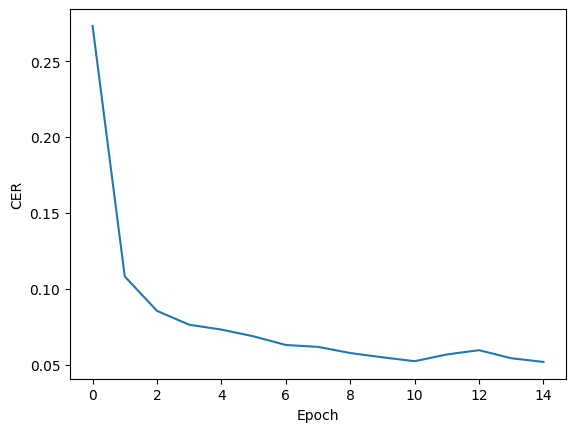

In [24]:
CER = [1 - (x / 100) for x in loss_hist["train accuracy"]]

plt.plot(CER)
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.show()

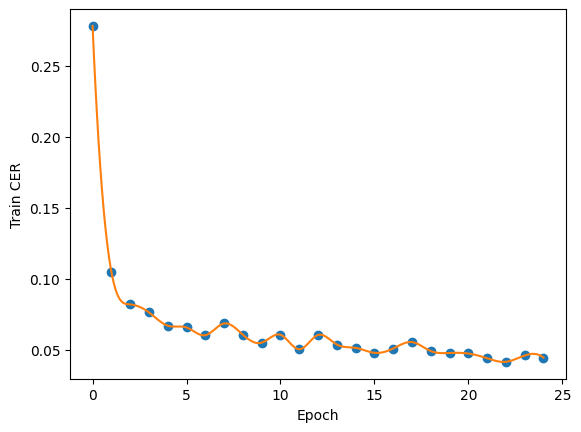

In [85]:
x_smooth = np.linspace(0, len(CER) - 1, 300)
spl = make_interp_spline(range(len(CER)), CER, k=3)
CER_smooth = spl(x_smooth)


plt.plot(range(len(CER)), CER, 'o')
plt.plot(x_smooth, CER_smooth, label='CER')
plt.xlabel("Epoch")
plt.ylabel("Train CER")
plt.show()

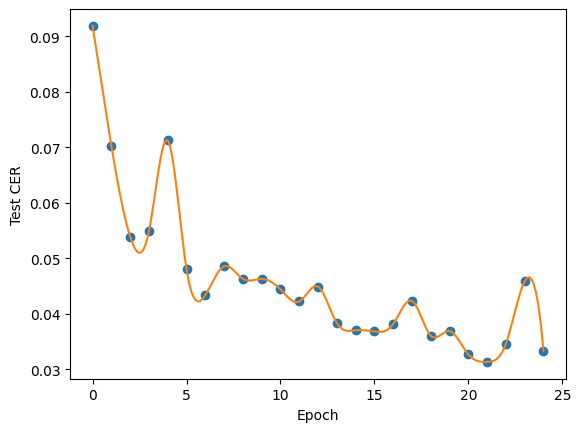

In [91]:
CER = [1 - (x / 100) for x in loss_hist["test accuracy"]]


x_smooth = np.linspace(0, len(CER) - 1, 300)
spl = make_interp_spline(range(len(CER)), CER, k=3)
CER_smooth = spl(x_smooth)


plt.plot(range(len(CER)), CER, 'o')
plt.plot(x_smooth, CER_smooth, label='CER')
plt.xlabel("Epoch")
plt.ylabel("Test CER")
plt.show()

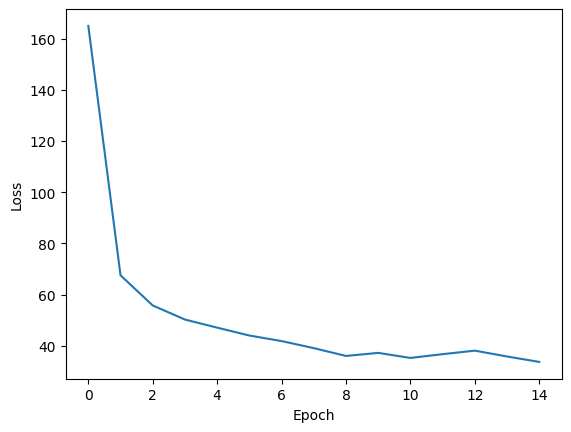

In [25]:
plt.plot(loss_hist["train loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

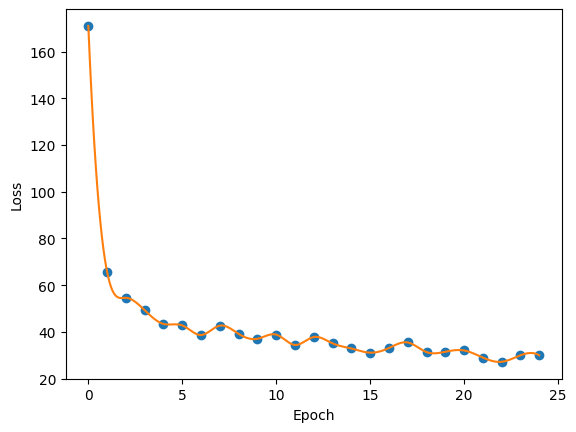

In [92]:
train_loss = loss_hist["train loss"]


x_smooth = np.linspace(0, len(train_loss) - 1, 300)
spl = make_interp_spline(range(len(train_loss)), train_loss, k=3)
CER_smooth = spl(x_smooth)


plt.plot(range(len(train_loss)), train_loss, 'o')
plt.plot(x_smooth, CER_smooth)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

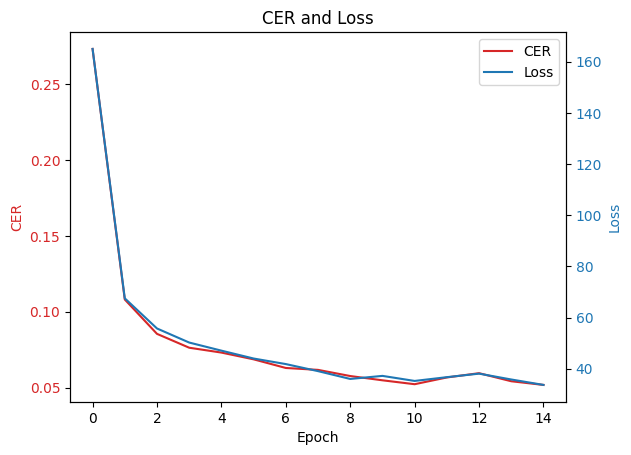

In [52]:
fig, ax1 = plt.subplots()

# Plot CER on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('CER', color=color)
ax1.plot(CER, color=color, label='CER')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot loss
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(loss_hist["train loss"], color=color, label='Loss')
ax2.tick_params(axis='y', labelcolor=color)

# Display legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Display the plot
plt.title('CER and Loss')
plt.show()

In [26]:
with torch.no_grad():
    model.eval()
    
    y_true_test = []
    y_pred_test = []
    
    for batch_idx, (img, labels) in tqdm(enumerate(testloader)):
        img = img.to(device)
        labels = labels.to(device)
    
        preds = model(img)
        
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
        
    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total
    
    print("Test Accuracy%: ", accuracy, "==", total_correct, "/", total)

0it [00:00, ?it/s]

Test Accuracy%:  95.89375 == 230145 / 240000


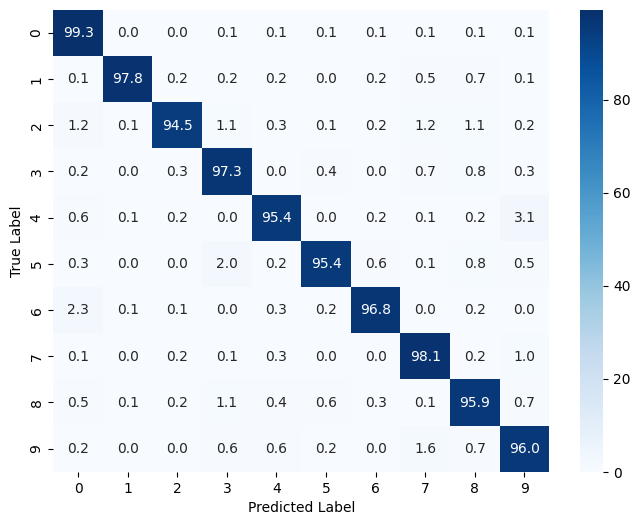

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Replace these with your true and predicted labels
true_labels = np.array(y_true_test)
predicted_labels = np.array(y_pred_test)

cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(10))

# Calculate relative values (percentages)
cm_relative = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_relative, annot=True, fmt='.1f', cmap='Blues', cbar=True,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [28]:
cer = 1 - (accuracy / 100)
print("CER: ", cer)

CER:  0.0410625


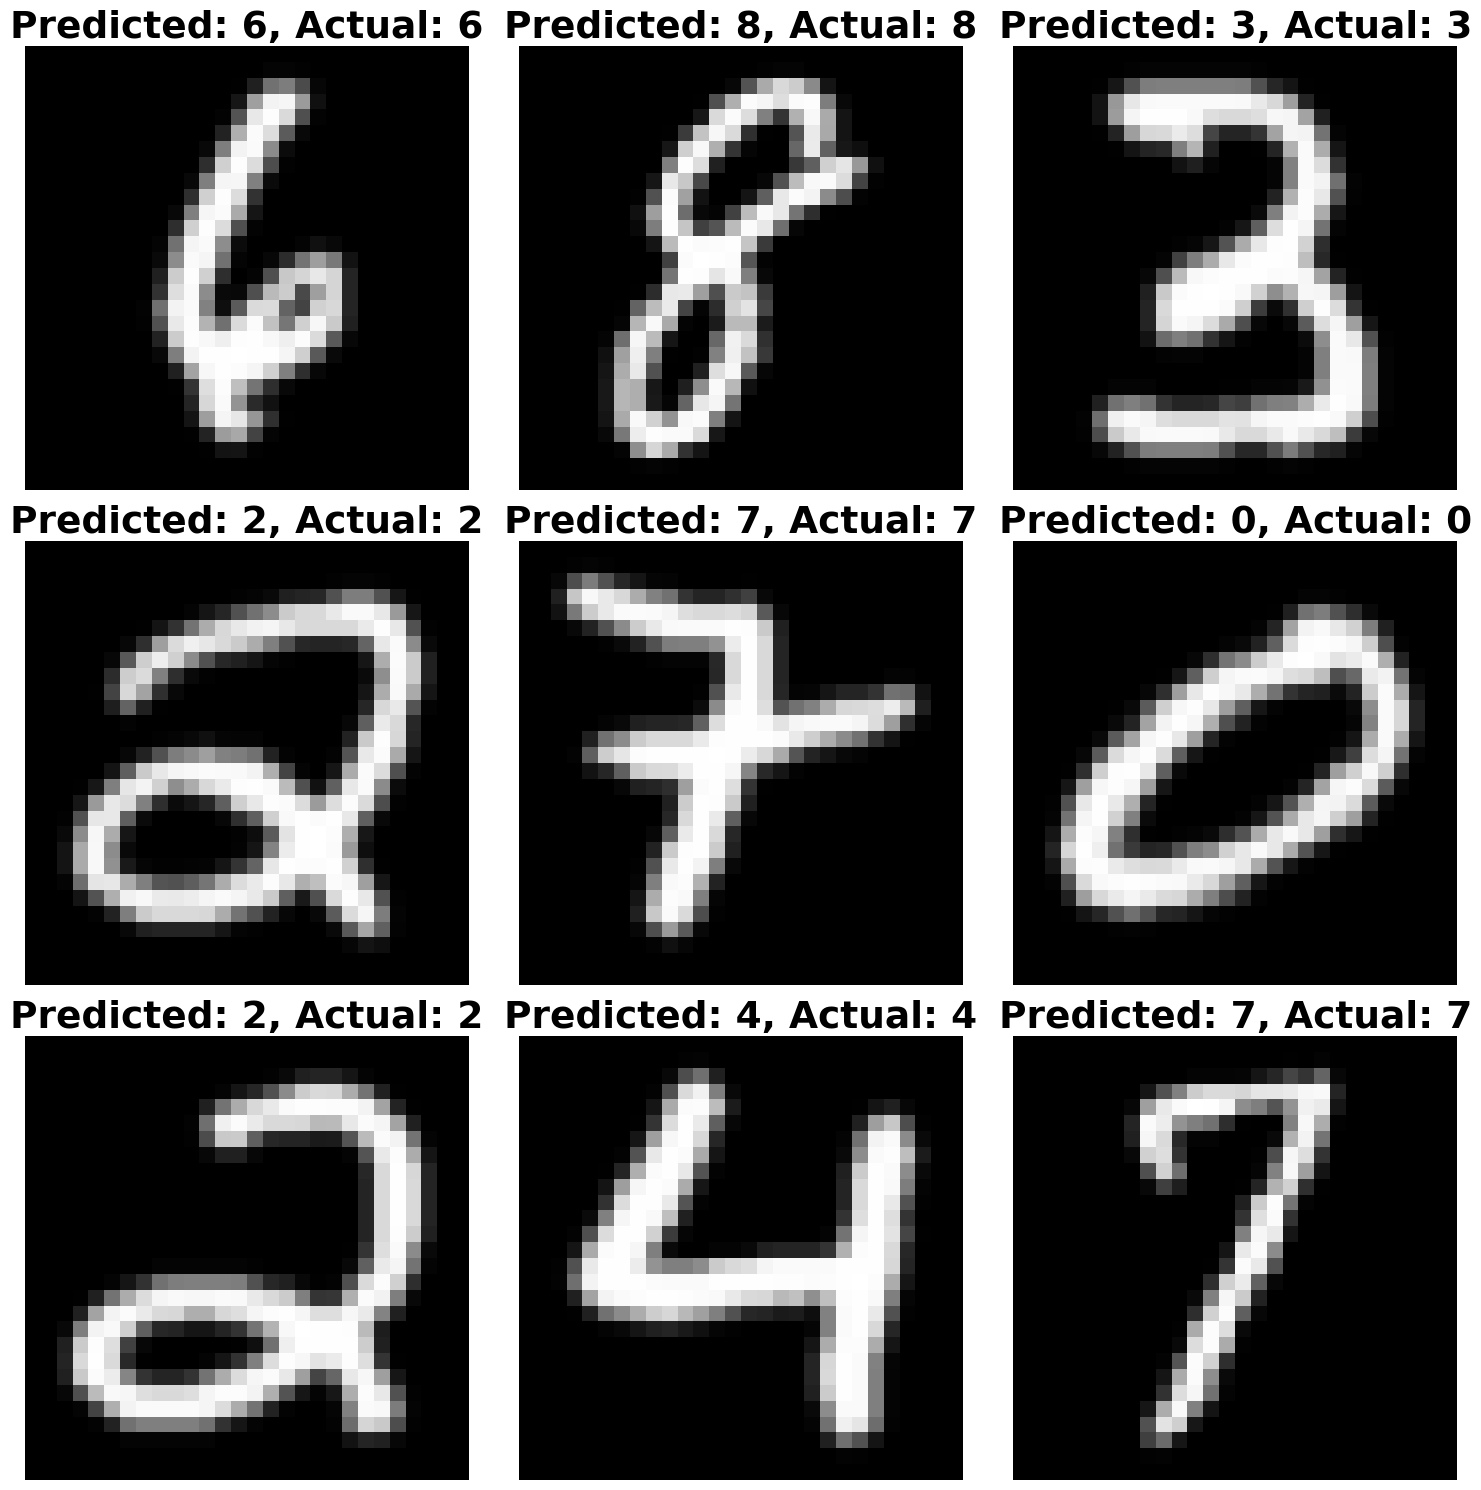

In [49]:
import random

# Assuming 'device' and 'model' are defined earlier in your code

num_rows = (9) // 3  # Adding 1 to ensure all images are shown

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

for i in range(9):
    index = random.randint(0, len(trainloader.dataset) - 1)
    img, label = trainloader.dataset[index]
    img = img.unsqueeze(0)

    # Get the model prediction
    with torch.no_grad():
        model.eval()
        pred = model(img)
        predicted_label = pred.argmax(dim=1).item()

    # Calculate subplot indices
    row = i // 3
    col = i % 3

    # Display the image, predicted label, and actual label in the corresponding subplot
    axes[row, col].imshow(img.squeeze().cpu().numpy().transpose(1, 0), cmap="gray")
    axes[row, col].set_title(f'Predicted: {predicted_label}, Actual: {label}', fontsize=27, fontweight='bold')
    axes[row, col].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# ================================================ TRAINING MODEL ======================================================
for _ in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        optimizer.zero_grad()
        y_pred = model(x_train)
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)

    # ============================================ VALIDATION ==========================================================
    val_correct = 0
    val_total = 0
    for x_val, y_val in tqdm(val_loader,
                             position=0, leave=True,
                             file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
        batch_size = x_val.shape[0]
        x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
        y_pred = model(x_val)
        y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_val])
        criterion(y_pred, y_val, input_lengths, target_lengths)
        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                val_correct += 1
            val_total += 1
    print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total)

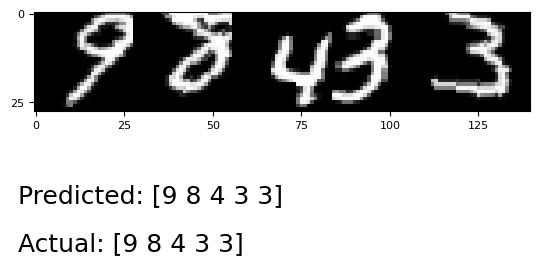

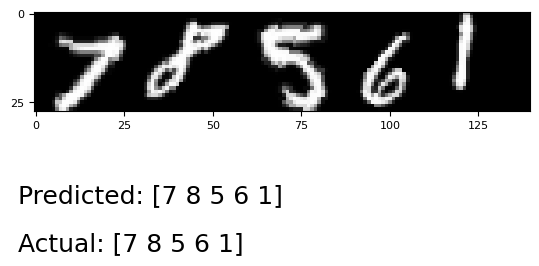

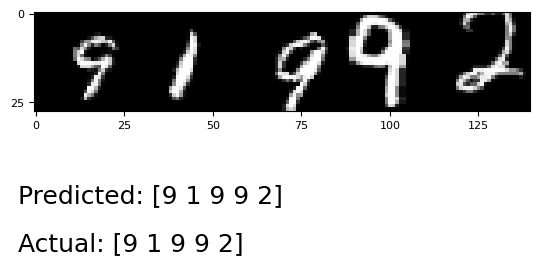

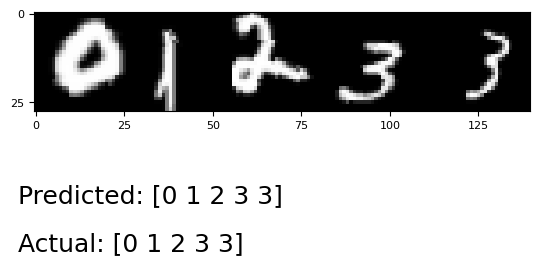

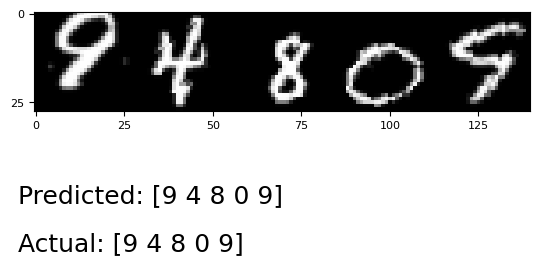

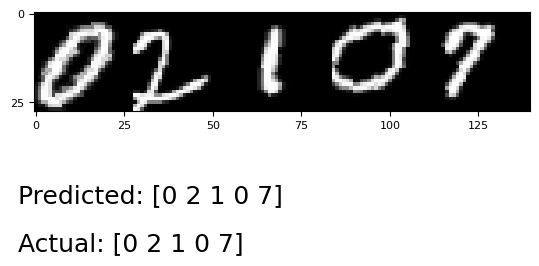

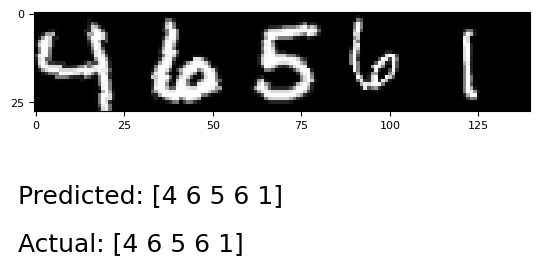

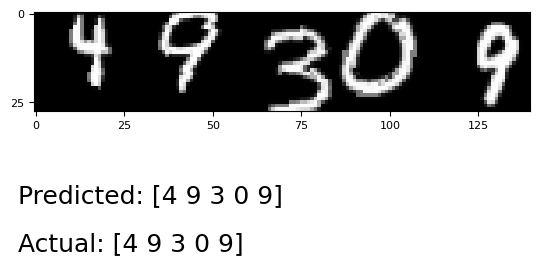

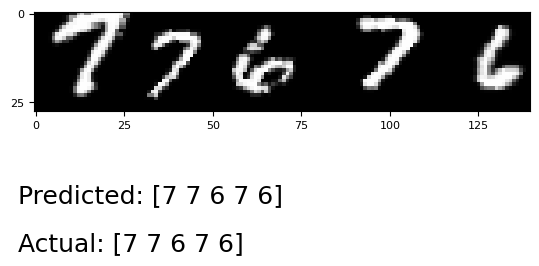

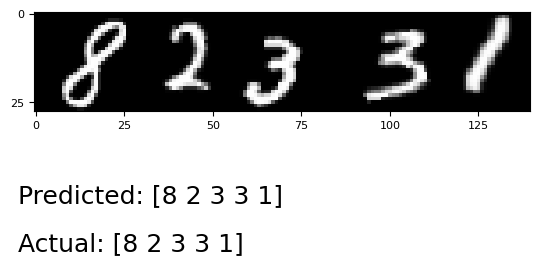

In [ ]:
# ============================================ TESTING =================================================================
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

for j in range(len(x_test)):
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j], cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()

In [ ]:
x_test[0].shape

torch.Size([28, 140])